In the notebook 'FEAT' we started working on the featues, we derived the remaining cylces and used a sliding window to average the measurements over 10 cycles.

Now we will start to use the features using a PCA model. The components are used to derive a basic function for the rul calclulation, additionaly we will use the PCA component as input for a linear regression model to see if we can actually determine the moment of failure.

In [1]:
# check if we have the data sets
!ls -l *.h5

-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users   994792 Mar  2 05:18 binary_model.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users  2942744 Feb 26 15:04 pd_test_fd001_scaled.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users  7623224 Feb 26 15:18 pd_test_fd002_scaled.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users  3726744 Feb 26 15:24 pd_test_fd003_scaled.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users  9241176 Feb 26 15:36 pd_test_fd004_scaled.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users 10385416 Mar  2 09:28 pd_train_enriched_rul_fd001.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users 25359424 Mar  2 09:28 pd_train_enriched_rul_fd002.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users 12233664 Mar  2 09:28 pd_train_enriched_rul_fd003.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users 16495136 Mar  2 09:28 pd_train_enriched_rul_fd004.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users  5764072 Feb 26 15:04 pd_train_fd001

In [2]:
# load data set one (the whole set)
from pandas import HDFStore

store = HDFStore('pd_train_enriched_rul_fd001.h5', mode='r')
pd_train_fd001 = store['pd']
store.close()

In [3]:
# quick check
pd_train_fd001[8:16]

,unit,cycle,opset1,opset2,opset3,sensor01,sensor02,sensor03,sensor04,sensor05,...,avgsensor13,avgsensor14,avgsensor15,avgsensor16,avgsensor17,avgsensor18,avgsensor19,avgsensor20,avgsensor21,avgrul
8,1,0.022161,0.545977,0.583333,0.0,0.0,0.274088,0.434706,0.211851,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,0.024931,0.310345,0.583333,0.0,0.0,0.150602,0.440374,0.307393,0.0,...,0.241350,0.166622,0.321241,0.0,0.316667,0.0,0.0,0.654264,0.684065,186.5
10,1,0.027701,0.603448,0.250000,0.0,0.0,0.322291,0.233485,0.310432,0.0,...,0.239878,0.167634,0.326820,0.0,0.316667,0.0,0.0,0.644961,0.692308,185.5
11,1,0.030471,0.591954,0.666667,0.0,0.0,0.256016,0.269675,0.302161,0.0,...,0.232520,0.169058,0.312199,0.0,0.308333,0.0,0.0,0.649613,0.684355,184.5
12,1,0.033241,0.390805,0.833333,0.0,0.0,0.560235,0.243076,0.313639,0.0,...,0.239878,0.166411,0.311198,0.0,0.333333,0.0,0.0,0.648062,0.674896,183.5
13,1,0.036011,0.551724,0.500000,0.0,0.0,0.343359,0.477652,0.285450,0.0,...,0.228105,0.166720,0.322049,0.0,0.341667,0.0,0.0,0.671318,0.676098,182.5
14,1,0.038781,0.396552,0.250000,0.0,0.0,0.367460,0.278611,0.335584,0.0,...,0.233991,0.163500,0.318393,0.0,0.325000,0.0,0.0,0.678295,0.668586,181.5
15,1,0.041551,0.534483,0.916667,0.0,0.0,0.277103,0.369303,0.375591,0.0,...,0.239878,0.165183,0.311775,0.0,0.333333,0.0,0.0,0.677520,0.680751,180.5


In [4]:
# load the test set on
store = HDFStore('pd_test_fd001_scaled.h5', mode='r')
pd_test_fd001 = store['pd']
store.close()

In [5]:
# quick check
pd_test_fd001.head(8)

,unit,cycle,opset1,opset2,opset3,sensor01,sensor02,sensor03,sensor04,sensor05,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,cycleoriginal
0,1,0.000000,0.65625,0.692308,0.0,0.0,0.596222,0.421968,0.282213,0.0,...,0.325766,0.152257,0.347076,0.0,0.375,0.0,0.0,0.500000,0.620101,1
1,1,0.003311,0.34375,0.230769,0.0,0.0,0.182972,0.504023,0.225241,0.0,...,0.395573,0.277907,0.227707,0.0,0.500,0.0,0.0,0.645455,0.645719,2
2,1,0.006623,0.53125,0.538462,0.0,0.0,0.419566,0.464812,0.346129,0.0,...,0.325766,0.192892,0.533559,0.0,0.500,0.0,0.0,0.700001,0.681104,3
3,1,0.009934,0.77500,0.461538,0.0,0.0,0.413251,0.391585,0.449868,0.0,...,0.372304,0.217894,0.282358,0.0,0.250,0.0,0.0,0.627272,0.620382,4
4,1,0.013245,0.60000,0.461538,0.0,0.0,0.435335,0.471303,0.357975,0.0,...,0.325766,0.187890,0.337009,0.0,0.125,0.0,0.0,0.618183,0.676009,5
5,1,0.016556,0.58750,0.692308,0.0,0.0,0.309144,0.261749,0.219318,0.0,...,0.442111,0.169315,0.436244,0.0,0.375,0.0,0.0,0.545454,0.582167,6
6,1,0.019868,0.51250,0.615385,0.0,0.0,0.309144,0.371330,0.417602,0.0,...,0.395573,0.236382,0.280922,0.0,0.250,0.0,0.0,0.490907,0.650816,7
7,1,0.023179,0.55000,0.461538,0.0,0.0,0.444789,0.307712,0.336941,0.0,...,0.395573,0.155654,0.424257,0.0,0.500,0.0,0.0,0.672726,0.547770,8


#### Model #1 : PCA 
<br/>
Given the assignment we can choose using an auto-encoder, PCA or clustering for unsupervised learning. <br/>
<br/>
For the first approach we choose the Principle Component Analysis (PCA), using the enriched dataset FD001. <br/>
Its one way to see if we can reduce the dataset, specifically the number of features.

In [6]:
# use all engine data for training.

# so we can drop the engine number (unit) , and the earlier added condition, faultmode, failcylce, and total failed (which is are static values)
# also for the first run we dont use the averaged data

train_fd001_subset = pd_train_fd001[['cycle','opset1', 'opset2', 'opset3',\
                                     'sensor01', 'sensor02', 'sensor03', 'sensor04', 'sensor05', 'sensor06', 'sensor07', 'sensor08', 'sensor09', 'sensor10', \
                                     'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21']]
train_fd001_subset.head()

,cycle,opset1,opset2,opset3,sensor01,sensor02,sensor03,sensor04,sensor05,sensor06,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,0.00000,0.459770,0.166667,0.0,0.0,0.183730,0.406800,0.309757,0.0,1.0,...,0.633256,0.206030,0.199609,0.363989,0.0,0.333333,0.0,0.0,0.713179,0.724662
1,0.00277,0.609195,0.250000,0.0,0.0,0.283133,0.453017,0.352634,0.0,1.0,...,0.765464,0.279612,0.162815,0.411313,0.0,0.333333,0.0,0.0,0.666667,0.731012
2,0.00554,0.252874,0.750000,0.0,0.0,0.343359,0.369522,0.370526,0.0,1.0,...,0.795305,0.220747,0.171793,0.357446,0.0,0.166667,0.0,0.0,0.627908,0.621375
3,0.00831,0.540230,0.500000,0.0,0.0,0.343359,0.256159,0.331195,0.0,1.0,...,0.889122,0.294329,0.174890,0.166605,0.0,0.333333,0.0,0.0,0.573644,0.662385
4,0.01108,0.390805,0.333333,0.0,0.0,0.349389,0.257465,0.404625,0.0,1.0,...,0.746268,0.235463,0.174734,0.402081,0.0,0.416667,0.0,0.0,0.589149,0.704501


Divide Training set into X (the featues, the independent variables) and the desired outcome Y (the dependent variable)

In [7]:
from sklearn.decomposition import PCA

pcaf = PCA(0.95) # The PCA function, go for 95% of variance is maintained
#pcaf = PCA() # lets have a look at all components
principleComponents_train_fd001 = pcaf.fit_transform(train_fd001_subset) # determine the pca components (apply dimension reduction)... and transform the training set


Lets see which components we find and to which featue they are related:

In [8]:
import pandas as pd

principalDf_fd001 = pd.DataFrame(data = principleComponents_train_fd001)

In [9]:
# just for overview
print(principalDf_fd001.head())
#print(principalDf_fd001.count())
# so we have 12 principle components for every row in the data set

         0         1         2         3         4         5         6   \
0 -0.485158  0.329654 -0.130176 -0.033194  0.037745  0.082560  0.157073   
1 -0.412604  0.245406 -0.165393 -0.019875 -0.111719  0.090937  0.097756   
2 -0.488337 -0.251607 -0.121899 -0.031662  0.243490  0.103839 -0.002212   
3 -0.584397 -0.005656 -0.129221 -0.033093 -0.043487  0.049702 -0.054886   
4 -0.420384  0.164205 -0.123212 -0.031229  0.101701  0.113582 -0.025410   

         7         8         9         10        11  
0 -0.050917 -0.046223 -0.037086  0.066221  0.066950  
1 -0.103613 -0.074228 -0.010057  0.067805  0.016075  
2 -0.049061  0.077896  0.147226  0.057190  0.013124  
3  0.032233  0.041302  0.014076 -0.166666 -0.033104  
4  0.090121 -0.095952 -0.025109  0.005525 -0.014466  


So we only need 12 (0..11) components to reflect the 24 features to explain 95% of the variance.<br/>

Which was to be expected, given the fact that 'sensor01', and 'sensor05' just had a foxed value (in train set FD001)<br/>
How much does one principle component add? To show how much each principal component explains the variance within the data, a scree plot is constructed.<br/>

Note: on an earlier run i did not use the cycle normalised, then PCA only concludes that the cycle is the only factor needed. Mmm.

In [10]:
# First quick check on the explaned variance ratio
print(pcaf.explained_variance_ratio_)

[ 0.5098951   0.1541839   0.06828793  0.04805182  0.04087566  0.03340368
  0.02076482  0.01886172  0.01717455  0.0160922   0.01516575  0.01348332]


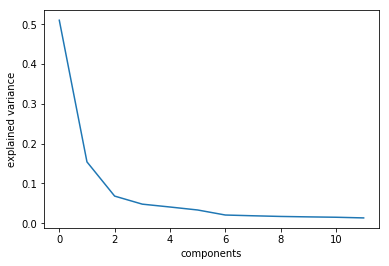

In [11]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#plt.plot(np.cumsum(pcaf.explained_variance_ratio_))
plt.plot(pcaf.explained_variance_ratio_)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 25
fig_size[1] = 15
plt.rcParams["figure.figsize"] = fig_size

plt.xlabel('components')
plt.ylabel('explained variance')
plt.show()

Note that we already limited the PCA algorithm to look for max 95% of the variance.<br/>

Lets say we use those components and we want to come up with a number of remaining cycles, i.e. we want to use a linear regression model using the Principle components.<br/>

The derived 'rul' would be the desired outcome (the dependent variable), i.e the target to predict later.

In [12]:
# just to see which the correlaction between the components and the features
# much like the table earlier but slighlty easier to read.
pd.DataFrame(pcaf.components_, columns=train_fd001_subset.columns, index = ['pc01', 'pc02', 'pc03', 'pc04', 'pc05','pc06','pc07','pc08', 'pc09','pc10','pc11', 'pc12'])

,cycle,opset1,opset2,opset3,sensor01,sensor02,sensor03,sensor04,sensor05,sensor06,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
pc01,0.322242,0.001852,0.011510,2.168404e-19,-6.776264e-21,0.277579,0.233079,0.308854,0.000000e+00,0.057114,...,-0.322548,0.194818,0.050555,0.278772,0.0,0.232611,0.0,0.0,-0.266391,-0.286272
pc02,-0.000563,-0.008056,-0.999782,-6.938894e-18,1.110223e-16,0.006643,0.004416,0.002586,0.000000e+00,-0.009188,...,-0.005091,-0.001221,0.006381,0.002202,0.0,0.002591,0.0,0.0,-0.004254,-0.006538
pc03,0.569435,-0.018207,0.005887,1.387779e-17,-0.000000e+00,-0.044400,0.039554,-0.045509,-5.421011e-20,-0.129707,...,0.142474,-0.245987,0.501705,-0.033051,0.0,0.036939,0.0,0.0,0.030127,0.027924
pc04,-0.075175,0.026320,0.009300,1.110223e-16,0.000000e+00,0.033838,0.026401,0.025959,0.000000e+00,-0.988973,...,-0.038262,0.036062,-0.054093,0.012663,-0.0,0.009295,-0.0,-0.0,-0.019348,-0.029487
pc05,0.022022,-0.997874,0.007757,-1.387779e-17,-1.387779e-17,-0.011397,0.015193,-0.005997,-1.110223e-16,-0.024477,...,-0.014297,0.016002,-0.027078,-0.005482,0.0,-0.001627,0.0,0.0,0.001625,0.020204
pc06,-0.745944,-0.044343,0.009564,2.775558e-17,1.387779e-17,0.163859,0.183537,0.068768,-3.469447e-18,0.026154,...,0.023236,-0.102568,0.392731,0.103240,-0.0,0.147063,-0.0,-0.0,-0.077429,-0.104578
pc07,-0.044822,0.012000,-0.002022,5.551115e-17,-9.714451e-17,-0.900280,0.370658,0.061694,1.110223e-16,-0.002661,...,-0.049541,0.019606,0.008237,0.080941,-0.0,0.068010,-0.0,-0.0,-0.094766,-0.124474
pc08,-0.054216,-0.022818,0.000056,-5.551115e-17,9.714451e-17,-0.248999,-0.856346,0.064490,-0.000000e+00,-0.015223,...,-0.025144,-0.005476,0.075347,0.154518,-0.0,0.200333,-0.0,-0.0,-0.196913,-0.277033
pc09,0.014684,-0.013841,0.003057,-5.551115e-17,-4.033232e-17,0.062575,0.077128,-0.102025,4.163336e-17,0.011543,...,0.042525,-0.011330,-0.021666,-0.284173,0.0,-0.234141,0.0,0.0,0.270060,-0.872979
pc10,-0.019471,-0.005385,0.001560,5.551115e-17,-3.989864e-17,0.004877,-0.020700,0.047571,-2.775558e-17,-0.000236,...,0.002715,-0.030084,0.051093,0.117741,0.0,-0.805919,0.0,0.0,-0.570015,-0.006641


Its clear that the operational setting 3, 'opset3' and sensors like 'sensor18' don't add much (as expected since their value don't change in this dataset.

In [13]:
# combine the components with target/desired/dependent
# assuming the order in the data is the same.
analysis_df001 = pd.concat( [principalDf_fd001, pd_train_fd001[['unit','rul']]]  , axis = 1 ) # axis 1 == columns

analysis_df001.rename(columns={ 0:'pc1', 1:'pc2'}, inplace=True) # rename colmn for cleares use

analysis_df001.head()

,pc1,pc2,2,3,4,5,6,7,8,9,10,11,unit,rul
0,-0.485158,0.329654,-0.130176,-0.033194,0.037745,0.082560,0.157073,-0.050917,-0.046223,-0.037086,0.066221,0.066950,1,191
1,-0.412604,0.245406,-0.165393,-0.019875,-0.111719,0.090937,0.097756,-0.103613,-0.074228,-0.010057,0.067805,0.016075,1,190
2,-0.488337,-0.251607,-0.121899,-0.031662,0.243490,0.103839,-0.002212,-0.049061,0.077896,0.147226,0.057190,0.013124,1,189
3,-0.584397,-0.005656,-0.129221,-0.033093,-0.043487,0.049702,-0.054886,0.032233,0.041302,0.014076,-0.166666,-0.033104,1,188
4,-0.420384,0.164205,-0.123212,-0.031229,0.101701,0.113582,-0.025410,0.090121,-0.095952,-0.025109,0.005525,-0.014466,1,187


Just to see how things look if we use the two main components directly for those engines which are at the end of theire lifetime, i.e. rul == 0.0.

In [14]:
# plot the two main components of the engines which died
analysis_df001.loc[analysis_df001['rul'] == 0.0].head(10)

,pc1,pc2,2,3,4,5,6,7,8,9,10,11,unit,rul
191,1.064530,0.011685,-0.344873,0.085374,-0.039190,-0.116781,0.049303,0.017950,0.143024,-0.031129,-0.014317,-0.052238,1,0
478,1.214155,-0.482127,0.238578,0.025073,0.031728,0.056650,0.008999,-0.087446,-0.064664,-0.093448,0.000563,-0.068858,2,0
657,1.107392,0.022498,0.486657,-0.003049,-0.101269,0.567226,0.103598,0.115365,0.088114,-0.045343,-0.083880,0.063218,3,0
846,1.190483,0.192495,0.536016,-0.006952,0.103576,0.643303,-0.137981,-0.137356,-0.069673,-0.048934,-0.024278,0.055101,4,0
1115,1.157826,-0.231936,0.401692,0.001100,-0.142816,0.180737,0.041206,0.184619,-0.005829,-0.015662,-0.000553,0.130119,5,0
1303,1.249339,0.346230,-0.450069,0.105847,-0.066150,-0.122194,0.108212,0.092306,0.061628,-0.063608,0.014750,0.017302,6,0
1562,1.117820,0.096513,0.002097,0.049342,-0.242980,-0.079644,-0.151832,-0.003410,0.015981,0.007835,0.001457,0.048179,7,0
1712,1.120906,0.263170,-0.357676,0.093809,-0.145023,0.041587,-0.007781,-0.016942,-0.025276,0.240787,0.046351,-0.028075,8,0
1913,1.288508,-0.308299,0.459287,0.004318,0.066782,0.561929,-0.114840,0.256361,-0.033950,-0.135473,-0.050586,0.076787,9,0
2135,0.978689,0.265614,0.199815,0.011402,-0.021884,0.152072,-0.036674,0.064977,-0.118596,-0.118972,-0.016905,0.050255,10,0


Will a pattern emerge when we check on the two main components of the engines died?

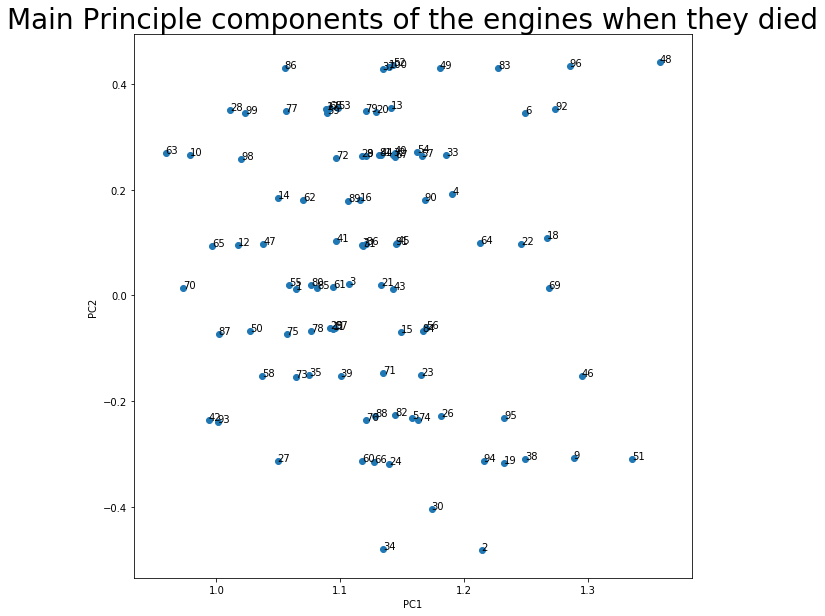

In [15]:
# can we see if the two main princicple components explain something about the remaing cyles
df = analysis_df001.loc[analysis_df001['rul'] == 0.0]

plt.figure(figsize=(10,10))
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(df['pc1'], df['pc2'])

#fig_size = plt.rcParams["figure.figsize"]
#fig_size[0] = 30
#fig_size[1] = 15
#plt.rcParams["figure.figsize"] = fig_size

# add the engine number
for i, txt in enumerate(df['unit']):
    ax.annotate(txt, (df['pc1'].iat[i], df['pc2'].iat[i]))
    
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("Main Principle components of the engines when they died", fontsize = 28)
plt.show()

The above picture does not really help a lot. Though some clustering seems visible.

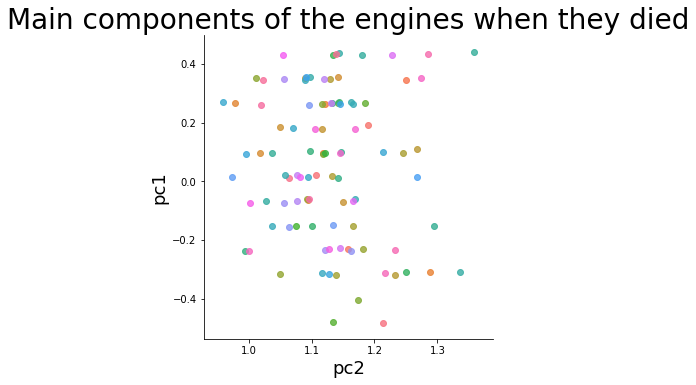

In [16]:
import seaborn as sns
from matplotlib import rcParams

#fig, ax = plt.subplots(figsize=(10,10))

sns.lmplot(x='pc1', y='pc2', data= df, fit_reg=False, hue='unit', legend=False)

# add annotations one by one with a loop
#for line in range(0, merged_train_fd001.loc[merged_train_fd001['rul'] == 0].shape[0]):
#     p1.text(df.pc2[line]+0.2, df.pc1[line], df.group[line], horizontalalignment='left', size='medium', color='black', weight='semibold')

#sns.set(rc={'figure.figsize':(30,20)})

#fig_size = plt.rcParams["figure.figsize"]
#fig_size[0] = 30
#fig_size[1] = 15
#plt.rcParams["figure.figsize"] = fig_size

plt.ylabel("pc1", fontsize = 18)
plt.xlabel("pc2", fontsize = 18)
plt.title("Main components of the engines when they died", fontsize = 28)

plt.show()

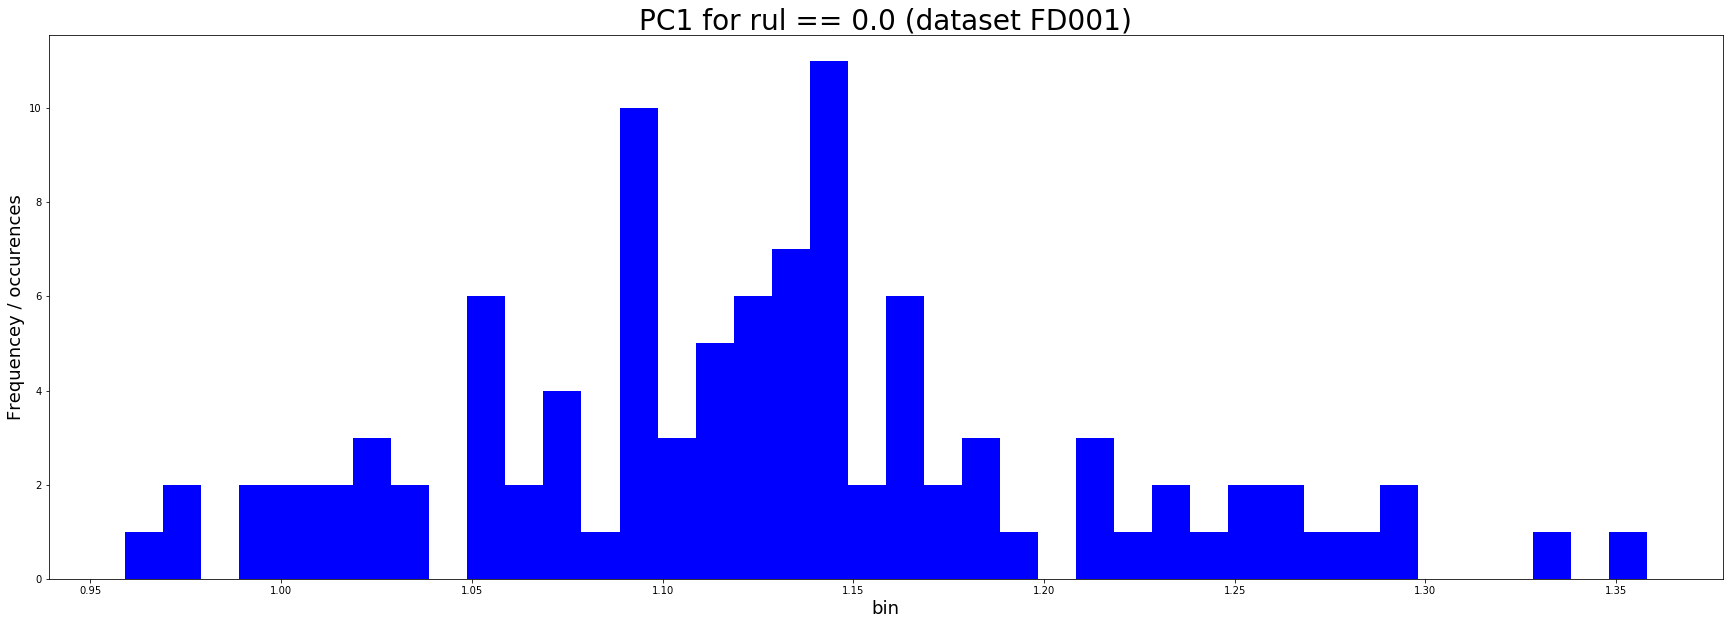

In [17]:
# Let scheck the histogram for pc1 for all engiens where the rul = 0
df = analysis_df001.loc[analysis_df001['rul'] == 0.0]

df['pc1'].plot(figsize = (30,10), kind = "hist", color = "blue", bins=40, legend = False)

plt.xlabel("bin", fontsize = 18)
plt.ylabel("Frequencey / occurences", fontsize = 18)
plt.title("PC1 for rul == 0.0 (dataset FD001)", fontsize = 28)

plt.show()

We could use PC1 as a main discriminator with a range 0f 1.05..1.20

Still seems roughly spread acoss the field. Not very particular grouped.

Using only the two main components a pattern of lines emerges.<br/>

So what if we look at one engine?

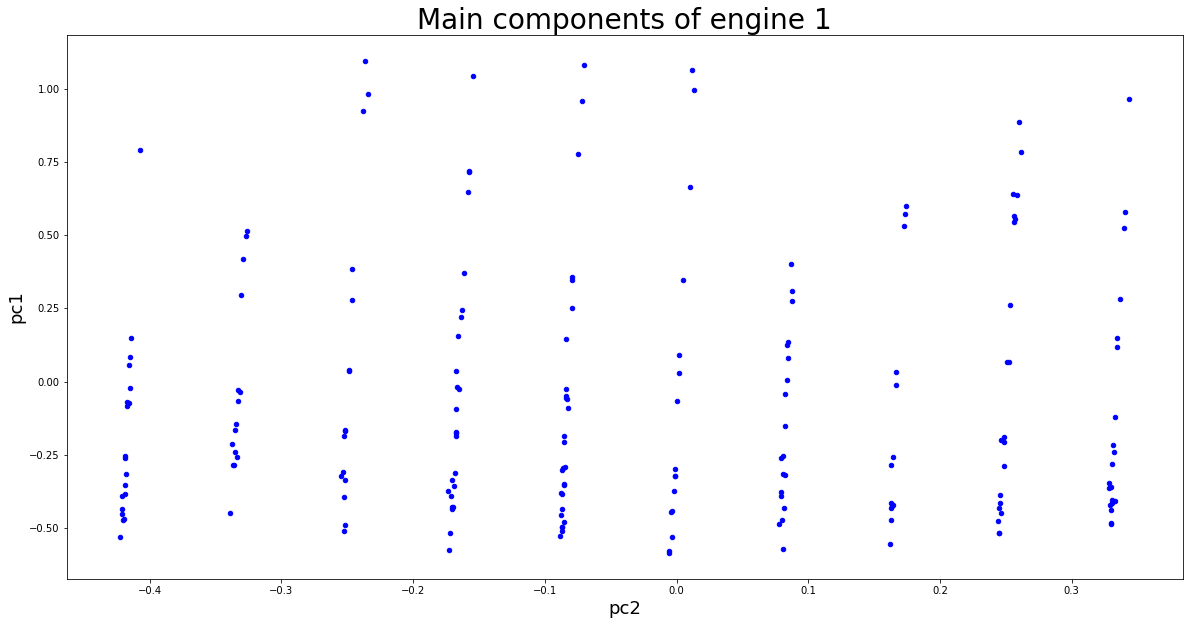

In [18]:
analysis_df001.loc[analysis_df001['unit'] == 1].plot(figsize = (20,10), kind = "scatter", color = "blue", y = "pc1", x = "pc2", legend = False)

plt.ylabel("pc1", fontsize = 18)
plt.xlabel("pc2", fontsize = 18)
plt.title("Main components of engine 1", fontsize = 28)

plt.show()

The same kind of pattern emerges. Ok so now we need to validate the model. Not a very clear correlation, since there are mulitple linaer relations (linesseen.<br/>

We change to project a bit, instead of predicting a number of remaining cycles we started, we want to raise an alarm if we are reasonbly sure that the engine is less than 21 cycles remaing.

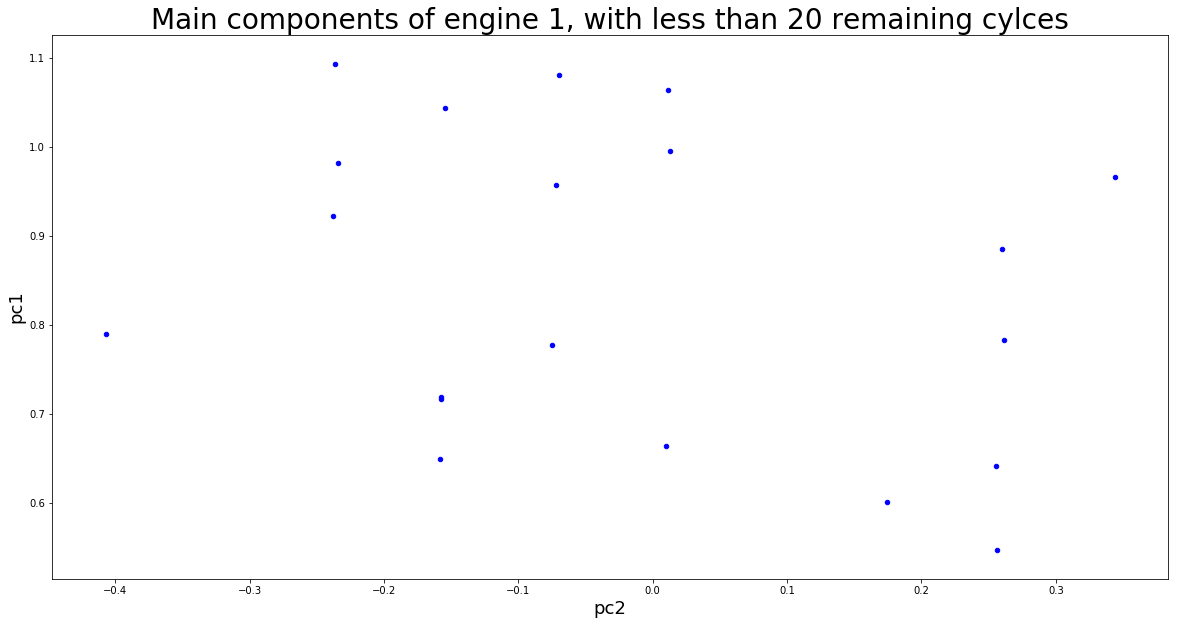

In [19]:
analysis_df001.loc[(analysis_df001['unit'] == 1) & (analysis_df001['rul'] < 20.0)].plot(figsize = (20,10), kind = "scatter", color = "blue", y = "pc1", x = "pc2", legend = False)

plt.ylabel("pc1", fontsize = 18)
plt.xlabel("pc2", fontsize = 18)
plt.title("Main components of engine 1, with less than 20 remaining cylces", fontsize = 28)

plt.show()

Its still hard to tell based on the two main principle components when an engine will die.<br/>
Lets plot them all.

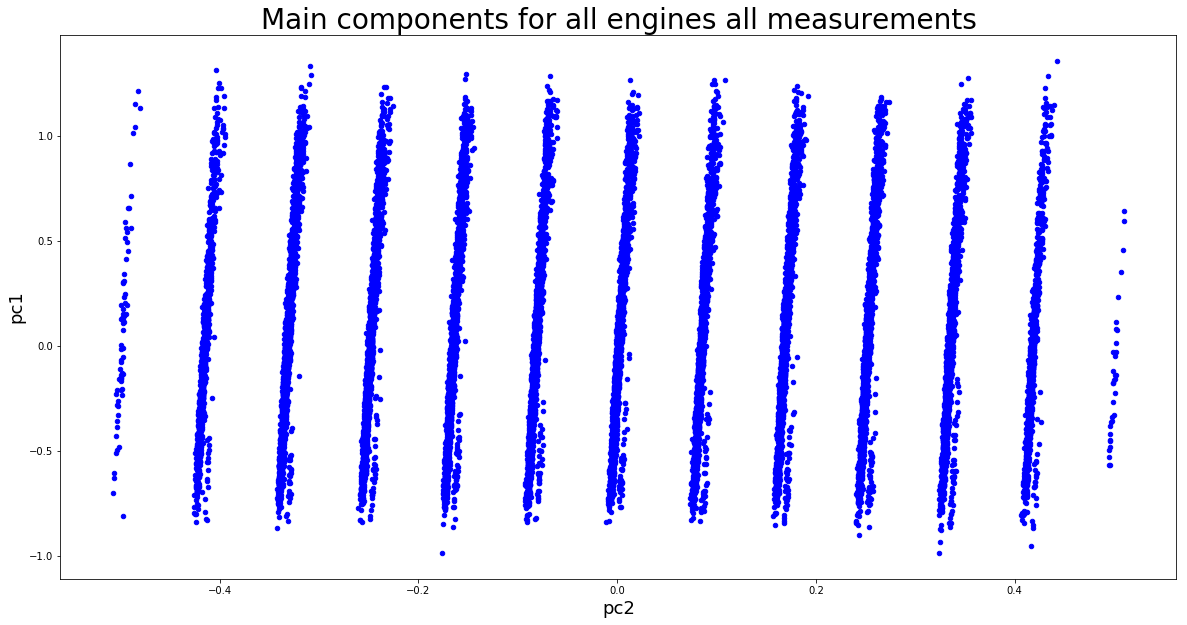

In [20]:
analysis_df001.plot(figsize = (20,10), kind = "scatter", color = "blue", y = "pc1", x = "pc2", legend = False)

plt.ylabel("pc1", fontsize = 18)
plt.xlabel("pc2", fontsize = 18)
plt.title("Main components for all engines all measurements", fontsize = 28)

plt.show()

Suppose we want to know when the last 20 cyles of an engine are started, will the pattern siginificantly change?<br/>
So lets check if we get a better picture when we plot all engines  with 21 or less remaing cycles.

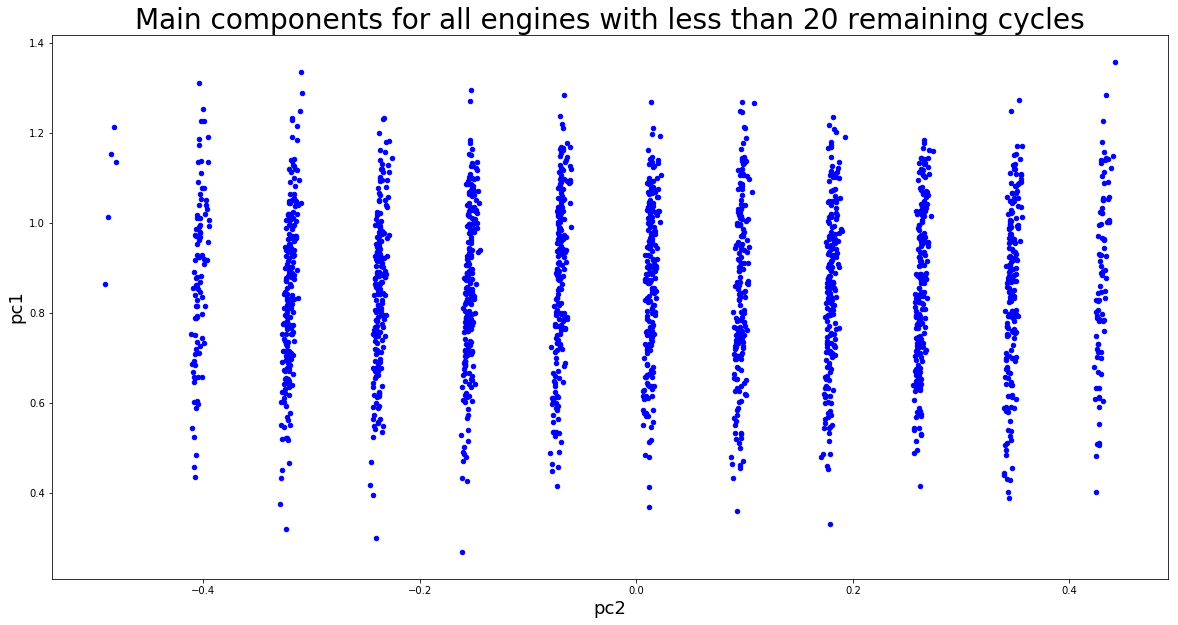

In [21]:
analysis_df001.loc[ (analysis_df001['rul'] < 20.0)].plot(figsize = (20,10), kind = "scatter", color = "blue", y = "pc1", x = "pc2", legend = False)

plt.ylabel("pc1", fontsize = 18)
plt.xlabel("pc2", fontsize = 18)
plt.title("Main components for all engines with less than 20 remaining cycles", fontsize = 28)

plt.show()

The pattern does not siginificantly change, only pc1 will help us for a quick rule, what would the pc1 value be exactly when we want to cut off at 20 cycles

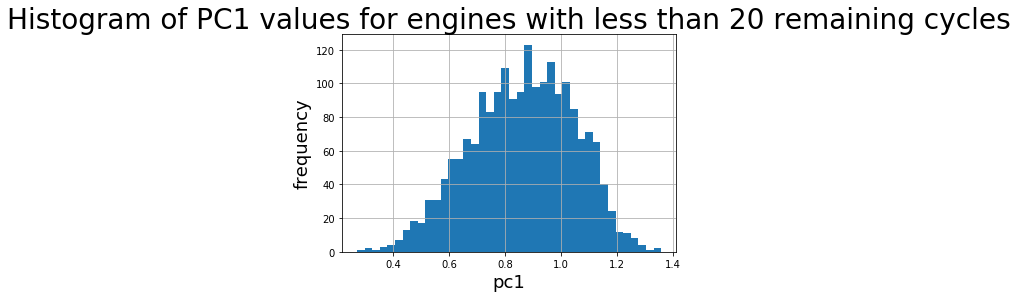

In [22]:
# which pc1 goes with this max rul
pc1values = analysis_df001.loc[analysis_df001['rul'] < 20.0] ['pc1']   #.sort_values(by=['pc1','rul','unit']).head(20)

pc1values.hist(bins=40)

plt.ylabel("frequency", fontsize = 18)
plt.xlabel("pc1", fontsize = 18)
plt.title("Histogram of PC1 values for engines with less than 20 remaining cycles", fontsize = 28)

plt.show()


So there isn't a very clear cutoff by just looking at pc1. W'ell cpature most enigine failures between 0.7 and 1.1, but that still seems imprecise.<br/>
Also we fiund a PC1 of 1.05 .. 1.2 when the rul is 0.0.

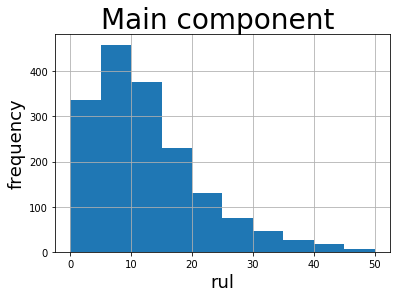

In [23]:
# lets see how many engine we will detect moment of failure within 20 cycles
subsets = analysis_df001.loc[(analysis_df001['pc1'] >= 0.7) & (analysis_df001['pc1'] <= 1.1) ]

subsets['rul'].hist()

plt.ylabel("frequency", fontsize = 18)
plt.xlabel("rul", fontsize = 18)
plt.title("Main component ", fontsize = 28)

plt.show()


In [24]:
# check how many engines we marked for failure wihtin 20 cycles
allwithin20 = analysis_df001.loc[analysis_df001['rul'] <= 20.0]
notwithin20 = analysis_df001.loc[analysis_df001['rul'] >  20.0]

markedtofailwithin20    = subsets

notmarkedtofailwithin20 = analysis_df001.loc[ ((analysis_df001['pc1'] < 0.7) | (analysis_df001['pc1'] > 1.1)) ]
   
print("#records", analysis_df001.shape[0])
print("#records of engines marked to fail within 20 cycles           (model) ", markedtofailwithin20.shape[0])
print("#records of engines marked to be healthy                      (model) ", notmarkedtofailwithin20.shape[0])

print("#records of all engines to fail within 20 cycles              (target)", allwithin20.shape[0])
print("#records of healthy engines (not to fail within 20 cycles)    (target)", notwithin20.shape[0])

healthybutmarked = subsets.loc[subsets['rul'] >  (20.0/361.0) ] # look in subset for engines which are not about to fail
print("#records wrongly marked about to fail                         (model) ", healthybutmarked.shape[0])

print("accuracy = ", ( (markedtofailwithin20.shape[0] - healthybutmarked.shape[0]) + (notwithin20.shape[0] - healthybutmarked.shape[0]) ) / (analysis_df001.shape[0]) )


#records 20631
#records of engines marked to fail within 20 cycles           (model)  1704
#records of engines marked to be healthy                      (model)  18927
#records of all engines to fail within 20 cycles              (target) 2100
#records of healthy engines (not to fail within 20 cycles)    (target) 18531
#records wrongly marked about to fail                         (model)  1667
accuracy =  0.8192041103194222


So this 'model' found 1805 engines soon to be defect while it should have found more, 2038. Also out of the 1805 it marked 315 while those engines were still healthy.
It seems the accuracy is misleading.

Alternatively we can use the PCA components as input for a next step instead of trying to use them directly. <br/>

** todo What if we use autoencoder as alternative? **

instead of linaer regression we could use logistic (so change it into a classification problem), predict failure within N cycles with a probablity > 80% or something?<br/>

We can enhance the data , not just calculating the rul, we can define a classification, i.e. the last 10 cycles is class 0, failure immenent, 20 cyles before, failure close etc, something like that. 
we didnt capture the time effect, should we somehow use the difference, max, std or average over N cyles?


In [25]:
#todo might use score for PCA model and see how that imporves when using rollong averageof pc1 for instance... 

In [26]:
pd_train_fd001.head()


,unit,cycle,opset1,opset2,opset3,sensor01,sensor02,sensor03,sensor04,sensor05,...,avgsensor13,avgsensor14,avgsensor15,avgsensor16,avgsensor17,avgsensor18,avgsensor19,avgsensor20,avgsensor21,avgrul
0,1,0.00000,0.459770,0.166667,0.0,0.0,0.183730,0.406800,0.309757,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.00277,0.609195,0.250000,0.0,0.0,0.283133,0.453017,0.352634,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.00554,0.252874,0.750000,0.0,0.0,0.343359,0.369522,0.370526,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.00831,0.540230,0.500000,0.0,0.0,0.343359,0.256159,0.331195,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.01108,0.390805,0.333333,0.0,0.0,0.349389,0.257465,0.404625,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
train_X = pd_train_fd001[['cycle', \
                          'opset1', 'opset2', 'opset3', \
                          'sensor01', 'sensor02', 'sensor03', 'sensor04', 'sensor05', 'sensor06', 'sensor07', 'sensor08', 'sensor09', 'sensor10',\
                          'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20','sensor21']]
# Dont use the condition, faultmode failcily or rul for training, normally you dont know failcycle and rul.
# We dont use the unit number (engine number) 

train_Y = pd_train_fd001[['rul']]

In [28]:
train_X.head()

,cycle,opset1,opset2,opset3,sensor01,sensor02,sensor03,sensor04,sensor05,sensor06,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,0.00000,0.459770,0.166667,0.0,0.0,0.183730,0.406800,0.309757,0.0,1.0,...,0.633256,0.206030,0.199609,0.363989,0.0,0.333333,0.0,0.0,0.713179,0.724662
1,0.00277,0.609195,0.250000,0.0,0.0,0.283133,0.453017,0.352634,0.0,1.0,...,0.765464,0.279612,0.162815,0.411313,0.0,0.333333,0.0,0.0,0.666667,0.731012
2,0.00554,0.252874,0.750000,0.0,0.0,0.343359,0.369522,0.370526,0.0,1.0,...,0.795305,0.220747,0.171793,0.357446,0.0,0.166667,0.0,0.0,0.627908,0.621375
3,0.00831,0.540230,0.500000,0.0,0.0,0.343359,0.256159,0.331195,0.0,1.0,...,0.889122,0.294329,0.174890,0.166605,0.0,0.333333,0.0,0.0,0.573644,0.662385
4,0.01108,0.390805,0.333333,0.0,0.0,0.349389,0.257465,0.404625,0.0,1.0,...,0.746268,0.235463,0.174734,0.402081,0.0,0.416667,0.0,0.0,0.589149,0.704501


In [29]:
train_Y.head()

,rul
0,191
1,190
2,189
3,188
4,187


In [30]:
test_X = pd_test_fd001[['cycle', \
                        'opset1', 'opset2', 'opset3', \
                        'sensor01', 'sensor02', 'sensor03', 'sensor04', 'sensor05', 'sensor06', 'sensor07', 'sensor08', 'sensor09', 'sensor10',\
                        'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20','sensor21']]
#  we dont use the unit number (engine number) 

In [31]:
from sklearn.decomposition import PCA

pca = PCA(0.95) # again we go for 95% of variance

In [32]:
# pass the training dataset (X_train) to pca's 'fit()' method
pcaf = pca.fit(train_X)

In [33]:
# how many components do we need in this run? 
# First quick check on the explaned variance ratio
print(pca.explained_variance_ratio_)

[ 0.5098951   0.1541839   0.06828793  0.04805182  0.04087566  0.03340368
  0.02076482  0.01886172  0.01717455  0.0160922   0.01516575  0.01348332]


In [34]:
train_X_pca = pca.transform(train_X)
test_X_pca  = pca.transform(test_X)

In [35]:
# using the PCA components for logistic regression as an enhancemanet on the PCA stand alone approavh of the first attmept
from sklearn.linear_model import LinearRegression # we need a range of values

model = LinearRegression()
reg = model.fit(train_X_pca, train_Y)

In [36]:
reg.score(train_X_pca, train_Y)

0.65535183569027367

Not a very good score.

Todo: better to calclate the RSME

In [37]:
print(list(test_X))

['cycle', 'opset1', 'opset2', 'opset3', 'sensor01', 'sensor02', 'sensor03', 'sensor04', 'sensor05', 'sensor06', 'sensor07', 'sensor08', 'sensor09', 'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21']


In [38]:
# find max number of cycles in test set (like we did for training)

test_max = pd_test_fd001.groupby(['unit'], sort=False)['unit','cycle'].max()
test_max.head()

,unit,cycle
unit,,
1,1,0.099338
2,2,0.158940
3,3,0.413907
4,4,0.347682
5,5,0.321192


In [39]:
# get the engine data, for one engine
unit = int(test_max[:1]['unit'])
max  = float(test_max[:1]['cycle'])
test_X_max = pd_test_fd001.loc[(pd_test_fd001['unit'] == unit) & (pd_test_fd001['cycle'] == max)]

In [40]:
# predict for one engine
test_X_max_pca = pca.transform(test_X_max[['cycle', \
                                             'opset1', 'opset2', 'opset3', \
                                             'sensor01', 'sensor02', 'sensor03', 'sensor04', 'sensor05', 'sensor06', 'sensor07', 'sensor08', 'sensor09', 'sensor10',\
                                             'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20','sensor21']])

rul = model.predict(test_X_max_pca)
#  we dont use the unit number (engine number) )

In [41]:
print("predicted rul ", rul)
print("Actual ", train_Y.head(1))

predicted rul  [[ 149.91654516]]
Actual     rul
0  191


In [42]:
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType
# load ground truth

# recreate structure based on readme.
schema = StructType([
    StructField("max"    , IntegerType(), True)
])
pd_rul_fd001 = spark.read.option("header", "false").option("delimiter", " ").csv('rul-cmapssdata/RUL_FD001.txt', schema=schema).toPandas()#.reset_index()

In [43]:
pd_rul_fd001['unit'] = np.arange(1,len(pd_rul_fd001)+1)
#pd_rul_fd001['rul_scaled'] = ((pd_rul_fd001['max'] - 1) / 361) # scaled using same factors as in training set
pd_rul_fd001.head()

,max,unit
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


So our model predicts way too much cycles for this engine. <br/>


In [44]:
#simpel check
model.score(test_X_max_pca, pd_rul_fd001.loc[(pd_rul_fd001['unit'] == 1)]['max'] )

0.0

Wrong approach. A really bad score.

In [45]:
# produce metrics for a model m, given a dataset X and target y
def metrics(m, X, y):
    yhat = m.predict(X)
    print("yhat        ", yhat)
    
    SS_Residual = sum((y-yhat)**2)
    SS_Total    = sum((y-np.mean(y))**2)
    print("SS_Residual ", SS_Residual)
    print("SS_Total    ", SS_Total)
        
    r_squared     = 1 - (float(SS_Residual))/SS_Total
    adj_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
    return r_squared,adj_r_squared

In [46]:
pd_rul_fd001.head()

,max,unit
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


In [47]:
import math

y=np.array([pd_rul_fd001.loc[(pd_rul_fd001['unit'] == 1)]['max'][0]])
#metrics(model, test_X_max_pca, y) not for single values

print("predicted ", rul, " Expected ", y, " RSME ", math.sqrt(math.pow(rul-y, 2)) )


predicted  [[ 149.91654516]]  Expected  [112]  RSME  37.91654515870252


The RSME as such doenst mean much (yet), we can use it to campare it against other runs, changed models.

In [48]:
# second metric,s all using sklearn routines

from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score

def metrics_sklearn(m, X, y):
    yhat = m.predict(X)
    print("explained_variance_score", explained_variance_score(y, yhat, multioutput='uniform_average')) # Explained variance regression score function: note input is y_true, y_pred
    print("mean_absolute_error     ", mean_absolute_error(y, yhat)) # Mean absolute error regression loss
    print("mean_squared_error      ", mean_squared_error(y, yhat))
    print("mean_squared_log_error  ", mean_squared_log_error(y, yhat)) # Mean squared logarithmic error regression loss
    print("median_absolute_error   ", median_absolute_error(y, yhat))
    print("r2_score                ", r2_score(y, yhat))

In [49]:
y=np.array([pd_rul_fd001.loc[(pd_rul_fd001['unit'] == 1)]['max'][0]])

metrics_sklearn(model, test_X_max_pca, y)


explained_variance_score 1.0
mean_absolute_error      37.9165451587
mean_squared_error       1437.66439677
mean_squared_log_error   0.0837171635424
median_absolute_error    37.9165451587
r2_score                 0.0


Clearly most of the statistics dont work for just one sample, lets test for all 100 engines.<br/>
th R2 score shows that the model is no good, really. Though the explained variance score is very good. <br/>

Lets see if we can a more realistic scoe when firrting all 100 engines.

In [50]:
test_X_max = pd_test_fd001.loc[(pd_test_fd001['cycle'] == max)]
test_X_max.head()

,unit,cycle,opset1,opset2,opset3,sensor01,sensor02,sensor03,sensor04,sensor05,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,cycleoriginal
30,1,0.099338,0.47500,0.769231,0.0,0.0,0.457420,0.316280,0.296509,0.0,...,0.395573,0.192979,0.333653,0.0,0.500,0.0,0.0,0.454546,0.594197,31
61,2,0.099338,0.53125,0.615385,0.0,0.0,0.517358,0.578548,0.369205,0.0,...,0.557889,0.187890,0.471717,0.0,0.625,0.0,0.0,0.390910,0.525265,31
110,3,0.099338,0.53125,0.307692,0.0,0.0,0.678245,0.439624,0.542985,0.0,...,0.488649,0.232271,0.600673,0.0,0.625,0.0,0.0,0.509089,0.562208,31
236,4,0.099338,0.54375,0.153846,0.0,0.0,0.312301,0.383537,0.456810,0.0,...,0.488649,0.198338,0.500958,0.0,0.375,0.0,0.0,0.636362,0.413589,31
342,5,0.099338,0.47500,0.769231,0.0,0.0,0.362786,0.674369,0.487033,0.0,...,0.488649,0.245134,0.391660,0.0,0.375,0.0,0.0,0.454546,0.624912,31


In [51]:
test_X_max_pca = pca.transform(test_X_max[['cycle', \
                                           'opset1', 'opset2', 'opset3', \
                                           'sensor01', 'sensor02', 'sensor03', 'sensor04', 'sensor05', 'sensor06', 'sensor07', 'sensor08', 'sensor09', 'sensor10',\
                                           'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20','sensor21']])
rul = model.predict(test_X_max_pca)

In [52]:
# now process the predicted rul for the 100 engines, i.e. compare with the ground truth
print(type(test_X_max_pca))
test_X_max_pca.shape

<class 'numpy.ndarray'>


(100, 12)

In [53]:
y = pd_rul_fd001['max']
print(type(y))
print(y.count())

<class 'pandas.core.series.Series'>
100


In [54]:
metrics_sklearn(model, test_X_max_pca, y)

explained_variance_score -0.282480094347
mean_absolute_error      67.8812926867
mean_squared_error       6678.2053311
mean_squared_log_error   1.43985488879
median_absolute_error    65.9348337119
r2_score                 -2.86723197345


It looks a bit contradicory, the 'explained vairancy score' and the 'r2 score' are bad, on the other hand the errors are quite small, thus indicating its reasonable.
What if we define our own score and give more weight to a predicted rul wich was too high than a rull which was to low. 

In [55]:
def our_loss(m, X, y):
    yhat = m.predict(X)
    
    total_error = 0
    
    for i in range(0, len(yhat)):
        #print(i)
        
        # if yhat > y: difference * 2
        if yhat[i] > y[i]:
            total_error += 2 * math.pow(yhat[i] - y[i], 2)
        else:
            # if yhat < y: difference * 1
            total_error += math.pow(y[i] - yhat[i], 2)
    return math.sqrt(total_error)

In [56]:
print(our_loss(model, test_X_max_pca, y))

1155.4620785300776


The loss doesn mean much as is, we can only use it to compare with a modified model or modified input of the same model.

## Conclusion for PCA model #1

The model scores not very good and we need improvement.<br/>
Or it could be the data doesn't fit the requirements for PCA as much as i thought.<br/>

Noote: one of the requirement/assumption is that the data (https://statistics.laerd.com/spss-tutorials/principal-components-analysis-pca-using-spss-statistics.php):<br/>
Assumption #1: You have multiple variables that should be measured at the continuous level : we're good on this one<br/>
Assumption #2: There needs to be a linear relationship between all variables. : the correlation tables also use this assumtpoin and it looked ok<br/>
Assumption #3: You should have sampling adequacy / large enough sample sizes are required: we have 200..300 sample per engine, not sure if this is good enough<br/>
Assumption #4: Your data should be suitable for data reduction: we've checked on the data correlation <br/>
Assumption #5: There should be no significant outliers: we do have outliers<br/>


Will the model improve if we use averaged values, i.e. we should have laees effect of outliers.

In [57]:
train_X_avg = pd_train_fd001[['cycle', \
                              'avgopset1', 'avgopset2', 'avgopset3', \
                              'avgsensor01', 'avgsensor02', 'avgsensor03', 'avgsensor04', 'avgsensor05', 'avgsensor06', 'avgsensor07', 'avgsensor08', 'avgsensor09', 'avgsensor10',\
                              'avgsensor11', 'avgsensor12', 'avgsensor13', 'avgsensor14', 'avgsensor15', 'avgsensor16', 'avgsensor17', 'avgsensor18', 'avgsensor19', 'avgsensor20','avgsensor21']]
# Dont use the condition, faultmode failcily or rul for training, normally you dont know failcycle and rul.
# We dont use the unit number (engine number) 

train_Y = pd_train_fd001[['rul']]

In [58]:
# quick check on the data 
train_X_avg.head(5)

,cycle,avgopset1,avgopset2,avgopset3,avgsensor01,avgsensor02,avgsensor03,avgsensor04,avgsensor05,avgsensor06,...,avgsensor12,avgsensor13,avgsensor14,avgsensor15,avgsensor16,avgsensor17,avgsensor18,avgsensor19,avgsensor20,avgsensor21
0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.00277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.00554,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.00831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.01108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
# drop rows with  Nans which resulted from averaging
train_X_avg.dropna(axis='rows', inplace=True)
train_X_avg.head(5)

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,cycle,avgopset1,avgopset2,avgopset3,avgsensor01,avgsensor02,avgsensor03,avgsensor04,avgsensor05,avgsensor06,...,avgsensor12,avgsensor13,avgsensor14,avgsensor15,avgsensor16,avgsensor17,avgsensor18,avgsensor19,avgsensor20,avgsensor21
9,0.024931,0.422414,0.491667,0.0,0.0,0.298485,0.363461,0.313808,0.0,1.0,...,0.736884,0.241350,0.166622,0.321241,0.0,0.316667,0.0,0.0,0.654264,0.684065
10,0.027701,0.436782,0.500000,0.0,0.0,0.312341,0.346129,0.313876,0.0,1.0,...,0.731341,0.239878,0.167634,0.326820,0.0,0.316667,0.0,0.0,0.644961,0.692308
11,0.030471,0.435057,0.541667,0.0,0.0,0.309630,0.327795,0.308828,0.0,1.0,...,0.721106,0.232520,0.169058,0.312199,0.0,0.308333,0.0,0.0,0.649613,0.684355
12,0.033241,0.448851,0.550000,0.0,0.0,0.331317,0.315150,0.303140,0.0,1.0,...,0.708952,0.239878,0.166411,0.311198,0.0,0.333333,0.0,0.0,0.648062,0.674896
13,0.036011,0.450000,0.550000,0.0,0.0,0.331317,0.337300,0.298565,0.0,1.0,...,0.683579,0.228105,0.166720,0.322049,0.0,0.341667,0.0,0.0,0.671318,0.676098


In [60]:
# same level of variance
pca = PCA(0.95) 
# pass the training dataset (X_train) to pca's 'fit()' method
pcaf = pca.fit(train_X_avg)

In [61]:
print(pca.explained_variance_ratio_)

[ 0.74254853  0.11807702  0.06668386  0.03048794]


Compared ith the earlier model we now only have 4 instead of the 12 components we had earlier.<br/>

First contsruct the averaged testset, by combning the ground truth table with the testset to determine thre rul.

In [62]:
# create rul from sepearet given datafile
from pyspark.sql.types import StructType, StructField, IntegerType
import numpy as np

schema = StructType([
    StructField("max"    , IntegerType(), True)
])
 
# lets load the data, only one file
pd_rul_fd001 = spark.read.option("header", "false").option("delimiter", " ").csv('rul-cmapssdata/RUL_FD001.txt', schema=schema).toPandas()
pd_rul_fd001['unit'] = np.arange(1,len(pd_rul_fd001)+1)
pd_rul_fd001.head()

,max,unit
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


In [63]:
# find max wihtin test set
# cycle is normalised, so we need the 'original' value
pd_rul_test_fd001 = pd_test_fd001.groupby('unit')['cycleoriginal'].max().reset_index()
pd_rul_test_fd001.head()

,unit,cycleoriginal
0,1,31
1,2,49
2,3,126
3,4,106
4,5,98


In [64]:
# We need to combine the ground truth table with test so we can test against the remaining usefull lifetime (test set does not contain rul on loading)
pd_rul_fd001['max_rul'] = pd_rul_fd001['max'] + pd_rul_test_fd001['cycleoriginal']  # assume both same order
pd_rul_fd001.head()

,max,unit,max_rul
0,112,1,143
1,98,2,147
2,69,3,195
3,82,4,188
4,91,5,189


In [65]:
pd_rul_fd001.drop(columns=['max'], inplace=True) # to prevent duplicate max

In [66]:
test_X = pd_test_fd001[['unit','cycle', 'cycleoriginal',\
                        'opset1', 'opset2', 'opset3', \
                        'sensor01', 'sensor02', 'sensor03', 'sensor04', 'sensor05', 'sensor06', 'sensor07', 'sensor08', 'sensor09', 'sensor10',\
                        'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20','sensor21']]
#  we dont use the unit number (engine number) 

In [67]:
# The test set stops at a point before the engine breaks down. So the maximum we find in test 
test_X = test_X.merge(pd_rul_fd001, on=['unit'], how='left') # left join
test_X.head()

,unit,cycle,cycleoriginal,opset1,opset2,opset3,sensor01,sensor02,sensor03,sensor04,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,max_rul
0,1,0.000000,1,0.65625,0.692308,0.0,0.0,0.596222,0.421968,0.282213,...,0.325766,0.152257,0.347076,0.0,0.375,0.0,0.0,0.500000,0.620101,143
1,1,0.003311,2,0.34375,0.230769,0.0,0.0,0.182972,0.504023,0.225241,...,0.395573,0.277907,0.227707,0.0,0.500,0.0,0.0,0.645455,0.645719,143
2,1,0.006623,3,0.53125,0.538462,0.0,0.0,0.419566,0.464812,0.346129,...,0.325766,0.192892,0.533559,0.0,0.500,0.0,0.0,0.700001,0.681104,143
3,1,0.009934,4,0.77500,0.461538,0.0,0.0,0.413251,0.391585,0.449868,...,0.372304,0.217894,0.282358,0.0,0.250,0.0,0.0,0.627272,0.620382,143
4,1,0.013245,5,0.60000,0.461538,0.0,0.0,0.435335,0.471303,0.357975,...,0.325766,0.187890,0.337009,0.0,0.125,0.0,0.0,0.618183,0.676009,143


In [68]:
# same as earlier, now we calcualte the rul per cycle
test_X['rul'] = test_X['max_rul'] - test_X['cycleoriginal']
test_X.head()

,unit,cycle,cycleoriginal,opset1,opset2,opset3,sensor01,sensor02,sensor03,sensor04,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,max_rul,rul
0,1,0.000000,1,0.65625,0.692308,0.0,0.0,0.596222,0.421968,0.282213,...,0.152257,0.347076,0.0,0.375,0.0,0.0,0.500000,0.620101,143,142
1,1,0.003311,2,0.34375,0.230769,0.0,0.0,0.182972,0.504023,0.225241,...,0.277907,0.227707,0.0,0.500,0.0,0.0,0.645455,0.645719,143,141
2,1,0.006623,3,0.53125,0.538462,0.0,0.0,0.419566,0.464812,0.346129,...,0.192892,0.533559,0.0,0.500,0.0,0.0,0.700001,0.681104,143,140
3,1,0.009934,4,0.77500,0.461538,0.0,0.0,0.413251,0.391585,0.449868,...,0.217894,0.282358,0.0,0.250,0.0,0.0,0.627272,0.620382,143,139
4,1,0.013245,5,0.60000,0.461538,0.0,0.0,0.435335,0.471303,0.357975,...,0.187890,0.337009,0.0,0.125,0.0,0.0,0.618183,0.676009,143,138


In [69]:
# only use columns we want (alternative drop the onse we dont want)
test_X = test_X[['unit','cycle', 'rul',\
                        'opset1', 'opset2', 'opset3', \
                        'sensor01', 'sensor02', 'sensor03', 'sensor04', 'sensor05', 'sensor06', 'sensor07', 'sensor08', 'sensor09', 'sensor10',\
                        'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20','sensor21']]

In [70]:
# Repair, forgot to average test

# columns to average over
# not: unit cycle, condition, faultmode, cycleoriginal, max, total_failed, rul.
columns = ['opset1', 'opset2', 'opset3',\
           'sensor01', 'sensor02', 'sensor03', 'sensor04', 'sensor05', 'sensor06', 'sensor07', 'sensor08', 'sensor09', 'sensor10', \
           'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21','rul']

test_X.sort_values(by=['unit','cycle'], ascending=True)

for column in columns:
    #print('avg'+column, column)
    newcolumn = 'avg'+column
    
    # Averaging existing column and place data in a new column
    # we are performing the operation mean() function finds the mean over each window 
    test_X[newcolumn]= test_X[column].rolling(10).mean() 

In [71]:
test_X.head(5)

,unit,cycle,rul,opset1,opset2,opset3,sensor01,sensor02,sensor03,sensor04,...,avgsensor13,avgsensor14,avgsensor15,avgsensor16,avgsensor17,avgsensor18,avgsensor19,avgsensor20,avgsensor21,avgrul
0,1,0.000000,142,0.65625,0.692308,0.0,0.0,0.596222,0.421968,0.282213,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.003311,141,0.34375,0.230769,0.0,0.0,0.182972,0.504023,0.225241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.006623,140,0.53125,0.538462,0.0,0.0,0.419566,0.464812,0.346129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.009934,139,0.77500,0.461538,0.0,0.0,0.413251,0.391585,0.449868,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.013245,138,0.60000,0.461538,0.0,0.0,0.435335,0.471303,0.357975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
# drop rows with  Nans which resulted from averaging
test_X_avg = test_X.dropna(axis='rows')
test_X_avg.head(5)

,unit,cycle,rul,opset1,opset2,opset3,sensor01,sensor02,sensor03,sensor04,...,avgsensor13,avgsensor14,avgsensor15,avgsensor16,avgsensor17,avgsensor18,avgsensor19,avgsensor20,avgsensor21,avgrul
9,1,0.029801,133,0.35625,0.384615,0.0,0.0,0.296532,0.420929,0.290995,...,0.374631,0.204768,0.372723,0.0,0.3375,0.0,0.0,0.602727,0.638755,137.5
10,1,0.033113,132,0.55625,0.153846,0.0,0.0,0.287059,0.311347,0.396977,...,0.381612,0.210867,0.366348,0.0,0.3250,0.0,0.0,0.620909,0.636972,136.5
11,1,0.036424,131,0.67500,0.692308,0.0,0.0,0.444789,0.477539,0.274248,...,0.381612,0.204357,0.375025,0.0,0.3000,0.0,0.0,0.629091,0.635967,135.5
12,1,0.039735,130,0.16250,0.692308,0.0,0.0,0.255521,0.520642,0.399223,...,0.381612,0.205268,0.361842,0.0,0.2875,0.0,0.0,0.629091,0.629046,134.5
13,1,0.043046,129,0.61875,0.153846,0.0,0.0,0.346997,0.366658,0.377578,...,0.383939,0.202946,0.379867,0.0,0.3000,0.0,0.0,0.631818,0.640865,133.5


In [73]:
test_X_avg = test_X_avg[['cycle', \
                              'avgopset1', 'avgopset2', 'avgopset3', \
                              'avgsensor01', 'avgsensor02', 'avgsensor03', 'avgsensor04', 'avgsensor05', 'avgsensor06', 'avgsensor07', 'avgsensor08', 'avgsensor09', 'avgsensor10',\
                              'avgsensor11', 'avgsensor12', 'avgsensor13', 'avgsensor14', 'avgsensor15', 'avgsensor16', 'avgsensor17', 'avgsensor18', 'avgsensor19', 'avgsensor20','avgsensor21']]
# Dont use the condition, faultmode failcily or rul for training, normally you dont know failcycle and rul.
# We dont use the unit number (engine number) 


In [74]:
train_X_avg_pca = pca.transform(train_X_avg)
test_X_avg_pca  = pca.transform(test_X_avg)

Finally we can now compare the results with the earlier run

In [75]:
model = LinearRegression()
reg = model.fit(train_X_avg_pca, train_Y[9:]) # same Y for target, but need to drop first 10 beacuse of rolling averega

In [76]:
reg.score(train_X_avg_pca, train_Y[9:])

0.60977204885026226

Score about the same as the earlier run

In [82]:
test_X_max = test_X_avg.loc[(test_X_avg['cycle'] == max)]
test_X_max.head()
#test_X_max.count()

,cycle,avgopset1,avgopset2,avgopset3,avgsensor01,avgsensor02,avgsensor03,avgsensor04,avgsensor05,avgsensor06,...,avgsensor12,avgsensor13,avgsensor14,avgsensor15,avgsensor16,avgsensor17,avgsensor18,avgsensor19,avgsensor20,avgsensor21
30,0.099338,0.567500,0.515385,0.0,0.0,0.367509,0.454115,0.333449,0.0,1.0,...,0.582191,0.416515,0.199580,0.418648,0.0,0.4000,0.0,0.0,0.566363,0.614354
61,0.099338,0.527500,0.500000,0.0,0.0,0.488644,0.520669,0.461731,0.0,1.0,...,0.489267,0.507208,0.188953,0.496309,0.0,0.4875,0.0,0.0,0.532727,0.519930
110,0.099338,0.560625,0.484615,0.0,0.0,0.542588,0.508179,0.446947,0.0,1.0,...,0.475571,0.514075,0.217582,0.522244,0.0,0.5750,0.0,0.0,0.501818,0.538132
236,0.099338,0.511875,0.415385,0.0,0.0,0.435645,0.534094,0.373310,0.0,1.0,...,0.525796,0.490863,0.199625,0.458485,0.0,0.4500,0.0,0.0,0.534545,0.528692
342,0.099338,0.480625,0.446154,0.0,0.0,0.449213,0.529368,0.475944,0.0,1.0,...,0.512784,0.435017,0.226959,0.455226,0.0,0.4375,0.0,0.0,0.488182,0.526412


In [83]:
test_X_max_pca = pca.transform(test_X_max[['cycle', \
                                           'avgopset1', 'avgopset2', 'avgopset3', \
                                           'avgsensor01', 'avgsensor02', 'avgsensor03', 'avgsensor04', 'avgsensor05', 'avgsensor06', 'avgsensor07', 'avgsensor08', 'avgsensor09', 'avgsensor10',\
                                           'avgsensor11', 'avgsensor12', 'avgsensor13', 'avgsensor14', 'avgsensor15', 'avgsensor16', 'avgsensor17', 'avgsensor18', 'avgsensor19', 'avgsensor20','avgsensor21']])
rul = model.predict(test_X_max_pca)

In [84]:
test_X_max_pca.shape

(100, 4)

In [85]:
y.count()

100

In [86]:
metrics_sklearn(model, test_X_max_pca, y)

explained_variance_score -0.148415215436
mean_absolute_error      76.8600322347
mean_squared_error       7871.10443658
mean_squared_log_error   1.54960206611
median_absolute_error    72.1429754288
r2_score                 -3.55801899378


In [87]:
print(our_loss(model, test_X_max_pca, y))

1254.6634982869036


So using averaged values did not really improve the PCA/linear regression approach.<br/>
Either the data doesn fit, or there is still an error somewhere in this approach.